In [1]:
try:
        
    import h5py
    import os

    import matplotlib.pyplot as mplt
    import numpy as np
    import seaborn as sns 
    import ipywidgets as widgets
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    import matplotlib.ticker as ticker
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")

All relevant classes imported


In [2]:

###### #### GUI 
current_folder = os.getcwd()
parent_folder = os.path.dirname(os.path.abspath(current_folder))
parent_folder2 = os.path.dirname(os.path.abspath(parent_folder)) #Note that HDF5 files are saved in a folder directly outside the repo as these files can be large.
hdf5_folder = os.path.join(parent_folder2, "HDF5_files")

os.chdir(hdf5_folder)

print(hdf5_folder)

edt_filename = widgets.Text(description = 'File name', value='test')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename ,btn_select,output_file)


def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    
    file_name = edt_filename.value
   
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]

            total_steps = total_t /dt          
            interval_step = total_steps / intervals

            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            print(intervals)
            print(interval_arr[0:5])
            print(total_steps)
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
                print(len(list(C_group.keys())))
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
            
         
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


        
btn_select.on_click(btn_select_clicked)

/Users/pyjamashark/Dropbox/Research/JVR/Code/Python/HDF5_files


Text(value='test', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

File found and content loaded into memory
100000
[0, 20, 40, 60, 80]
1999999.9999999998
100000
100000


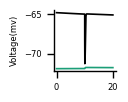

In [20]:
#################################################################



R = 8.31446
F: float = 96485.33  # Faraday's constant        C mol-1
T = 37 + 273.15
RTF = R * T / F

#end_int = 979667
end_int = len(t_arr)

na_arr = [master_arr[0][i][3]*1e3 for i in range(end_int)]
k_arr = [master_arr[0][i][4]*1e3 for i in range(end_int)]
cl_arr = [master_arr[0][i][5]*1e3 for i in range(end_int)]
hco3_arr = [master_arr[0][i][6]*1e3 for i in range(end_int)]
h_arr = [master_arr[0][i][7]*1e3 for i in range(end_int)]
x_arr = [master_arr[0][i][8]*1e3 for i in range(end_int)]
z_arr = [master_arr[0][i][9] for i in range(end_int)]
vm_arr = [master_arr[0][i][10]*1e3 for i in range(end_int)]
vol_arr = [master_arr[0][i][2]*1e13 for i in range(end_int)]

nao_arr = [master_arr[1][i][3]*1e3 for i in range(end_int)]
ko_arr = [master_arr[1][i][4]*1e3 for i in range(end_int)]
clo_arr = [master_arr[1][i][5]*1e3 for i in range(end_int)]
hco3o_arr = [master_arr[1][i][6]*1e3 for i in range(end_int)]
xo_arr = [master_arr[1][i][7]*1e3 for i in range(end_int)]
zo_arr = [master_arr[1][i][8] for i in range(end_int)]

       
E_k_arr = [-1 * RTF * np.log(k_arr[i] / ko_arr[i])*1e3 for i in range(end_int)]
E_cl_arr = [RTF * np.log(cl_arr[i] / clo_arr[i])*1e3 for i in range(end_int)]
E_hco3_arr = [RTF * np.log(hco3_arr[i] / hco3o_arr[i])*1e3 for i in range(end_int)] 

numerator = [4 / 5 * cl_arr[i] + 1 / 5 * hco3_arr[i] for i in range(end_int)] 
denominator = [4 / 5 * clo_arr[i] + 1 / 5 * hco3o_arr[i] for i in range(end_int)] 
E_gaba_arr = [RTF * np.log(numerator[i] / denominator[i])*1e3 for i in range(end_int)]  



df_cl_arr = [vm_arr[i] - E_cl_arr[i]  for i in range(end_int)] 
df_gaba_arr = [vm_arr[i] - E_gaba_arr[i]  for i in range(end_int)] 


####################################################################
# SET TIMING BUFFER

tmin_arr =[t_arr[i] for i in range(end_int)]
buffer = 0 #50000
#back_buffer = len(t_arr) - 4400 
back_buffer = 100000
####################################################################
# DEFINE FIGURE AND AXES 

f1, ax_1A = mplt.subplots( figsize=(0.8,0.8), sharex=True)
sns.set_context('paper')
col_arr= [ '#e7298a', '#1b9e77', '#7570b3' ,'#FF5800']

###################################################################



sns.despine(ax = ax_1A,bottom = False)


ax_1A.plot(tmin_arr[buffer:back_buffer], vm_arr[buffer:back_buffer],color='#000000', label ='Vm')
#ax_1A.plot(tmin_arr[buffer:], ek_arr[buffer:],color=col_arr[2], label='Ek')
ax_1A.plot(tmin_arr[buffer:back_buffer], E_gaba_arr[buffer:back_buffer], color=col_arr[1], label='ECl')


#ax_1A.legend(bbox_to_anchor=(0.8,0.4), loc = 'lower left', frameon=False,fontsize=8)

ax_1A.set_ylabel("Voltage(mv)",fontsize=6)
#ax_1A.set_ylim(-76, -69)

#mplt.xticks([])
ax_1A.tick_params(axis='both', which='major', labelsize=6)

#####################################################################

#ax_1A.set_xlabel("Time (s)",fontsize=14)


#######################################
file_name = "default_H_small_CO2_hydration_t1_synapse.svg"
current_folder = os.getcwd()
# Get the parent folder of the current working directory
parent_folder = os.path.dirname(os.path.abspath(current_folder))
hdf5_folder = os.path.join(parent_folder, "Jupyter_outputs")
# Create the "HDF5_files" folder if it doesn't exist
if not os.path.exists(hdf5_folder):
    os.makedirs(hdf5_folder)

file_name = os.path.join(hdf5_folder, file_name)

f1.savefig(file_name, dpi=2000, bbox_inches='tight')

In [7]:
print(max(vm_arr[:]))
print(min(vm_arr[:]))

-64.84651172474136
-71.24786400395624


In [21]:
file_name

'/Users/pyjamashark/Dropbox/Research/JVR/Code/Python/Jupyter_outputs/default_H_small_CO2_hydration_t1_synapse.svg'

In [5]:
len(na_arr)

100000

In [13]:
start_int = 40000

print(f"Initial time point @ {round(t_arr[start_int])} s")
print("")

print(f"[X]o: {round(xo_arr[start_int],2)} mM ----> {round(xo_arr[-1],2)} mM ({round(xo_arr[-1]-xo_arr[start_int],2)})" )
print(f"zo: {round(zo_arr[start_int],2)}  ----> {round(zo_arr[-1],2) }  ({round(zo_arr[-1]-zo_arr[start_int],2)})" )
print(f"----------------------------------------- " )

print(f"[Na]i: {round(na_arr[start_int],2)} mM ----> {round(na_arr[-1],2)} mM ({round(na_arr[-1]-na_arr[start_int],2)})" )
print(f"[K]i: {round(k_arr[start_int],2)} mM ----> {round(k_arr[-1],2) } mM ({round(k_arr[-1]-k_arr[start_int],2)})"  )
print(f"[Cl]i: {round(cl_arr[start_int],2)} mM ----> {round(cl_arr[-1],2)} mM ({round(cl_arr[-1]-cl_arr[start_int],2)})"  )
print(f"[HCO3]i: {round(hco3_arr[start_int],2)} mM ----> {round(hco3_arr[-1],2)} mM ({round(hco3_arr[-1]-hco3_arr[start_int],2)})"  )
print(f"[X]i: {round(x_arr[start_int],2)} mM ----> {round(x_arr[-1],2)} mM ({round(x_arr[-1]-x_arr[start_int],2)})" )
print(f"----------------------------------------- " )

print(f"Vm: {round(vm_arr[start_int],2)} mV ----> {round(vm_arr[-1],2)} mV ({round(vm_arr[-1]-vm_arr[start_int],2)})" )
print(f"EK: {round(E_k_arr[start_int],2)} mV ----> {round(E_k_arr[-1],2)} mV ({round(E_k_arr[-1]-E_k_arr[start_int],2)})" )
print(f"ECl: {round(E_cl_arr[start_int],2)} mV ----> {round(E_cl_arr[-1],2)} mV ({round(E_cl_arr[-1]-E_cl_arr[start_int],2)})" )
print(f"EGABA: {round(E_gaba_arr[start_int],2)} mV ----> {round(E_gaba_arr[-1],2)} mV ({round(E_gaba_arr[-1]-E_gaba_arr[start_int],2)})" )
print(f"DF-Cl: {round(df_cl_arr[start_int],2)} mv ----> {round(df_cl_arr[-1],2)} mV ({round(df_cl_arr[-1]-df_cl_arr[start_int],2)})" )
print(f"DF-GABA: {round(df_gaba_arr[start_int],2)} mv ----> {round(df_gaba_arr[-1],2)} mV ({round(df_gaba_arr[-1]-df_gaba_arr[start_int],2)})" )
print(f"----------------------------------------- " )
print(f"Volume: {round(vol_arr[start_int],2)} pL ----> {round(vol_arr[-1],2)} pL ({round(vol_arr[-1]-vol_arr[start_int],2)})" )
osmoi = round(na_arr[-1],7) + round(k_arr[-1],7) + round(cl_arr[-1],7) + round(x_arr[-1],7)
osmoo = round(nao_arr[-1],7) + round(ko_arr[-1],7) + round(clo_arr[-1],7) + round(xo_arr[-1],7)
osmo_diff = round((osmoi - osmoo),7)
print(f"Final osmo = {osmo_diff} mM")
electroi = round(na_arr[-1],7) + round(k_arr[-1],7) - round(cl_arr[-1],7) + (round(x_arr[-1],7)*z_arr[-1])
electroo = round(nao_arr[-1],7) + round(ko_arr[-1],7) - round(clo_arr[-1],7) + (round(xo_arr[-1],7)*zo_arr[-1])
electro_diff = round((electroi - electroo),5) 
print(f"Final electro = {electro_diff} mV")

Initial time point @ 8 s

[X]o: 0.0 mM ----> 0.0 mM (0.0)
zo: 0.01  ----> 0.01  (0.0)
----------------------------------------- 
[Na]i: 14.91 mM ----> 14.99 mM (0.08)
[K]i: 122.81 mM ----> 122.72 mM (-0.09)
[Cl]i: 5.46 mM ----> 5.51 mM (0.06)
[HCO3]i: 10.17 mM ----> 10.1 mM (-0.07)
[X]i: 143.65 mM ----> 143.66 mM (0.02)
----------------------------------------- 
Vm: -64.99 mV ----> -65.13 mV (-0.14)
EK: -95.09 mV ----> -95.07 mV (0.02)
ECl: -80.28 mV ----> -80.01 mV (0.28)
EGABA: -71.88 mV ----> -71.75 mV (0.13)
DF-Cl: 15.29 mv ----> 14.87 mV (-0.42)
DF-GABA: 6.89 mv ----> 6.62 mV (-0.27)
----------------------------------------- 
Volume: 19.12 pL ----> 19.12 pL (-0.0)
Final osmo = 28.3903023 mM
Final electro = -28.40795 mV


In [7]:
baseline_vm = vm_arr[start_int]
baseline_ecl = E_cl_arr[start_int]
baseline_eGABA = E_gaba_arr[start_int]


print(f" Baseline index: {start_int}")
print(f" Baseline Ecl: {round(baseline_ecl,3)} mV")
print(f" Baseline EGABA: {round(baseline_eGABA,3)} mV")
print(f"---")


max_vm = max(vm_arr[buffer:])
max_vm_index = vm_arr.index(max_vm)
max_ecl = E_cl_arr[max_vm_index]
max_eGABA = E_gaba_arr[max_vm_index]


print(f" Max index: {max_vm_index}")
print(f" Max Ecl: {round(max_ecl,3)} mV")
print(f" Max EGABA: {round(max_eGABA,3)} mV")
print(f"---")

eGABA_diff = round(max_eGABA -baseline_eGABA,3)
eGABA_percent_change = round(eGABA_diff/baseline_eGABA * 100,2) 
print(f" Difference in EGABA: {eGABA_diff}mV")
print(f" % change in EGABA: {eGABA_percent_change}%")
print(f"---") 

vm_diff = max_vm-baseline_vm
vm_percent_change = vm_diff / baseline_vm *100

print(f"Baseline Vm {round(baseline_vm,3)}mV")
print(f"Min Vm {round(max_vm,3)}mV")
print(f"Difference in Vm {round(vm_diff,3)}mV")
print(f"% change in Vm: {round(vm_percent_change,3)}%")
print(f"---") 


 Baseline index: 40000
 Baseline Ecl: -84.264 mV
 Baseline EGABA: -74.99 mV
---
 Max index: 50000
 Max Ecl: -84.256 mV
 Max EGABA: -74.985 mV
---
 Difference in EGABA: 0.005mV
 % change in EGABA: -0.01%
---
Baseline Vm -69.335mV
Min Vm -69.346mV
Difference in Vm -0.011mV
% change in Vm: 0.016%
---


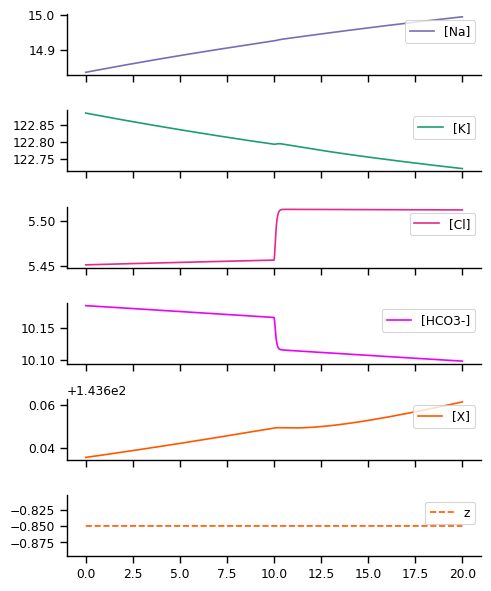

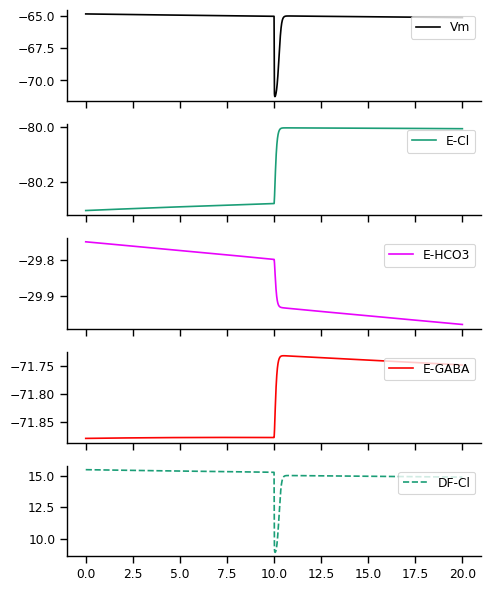

In [14]:
####################################################################
# DEFINE FIGURE AND AXES 

f1, axs = mplt.subplots(6,1, gridspec_kw={ 'height_ratios': [1, 1,1,1,1,1]}, figsize=(5,6), sharex=True)
sns.set_context('paper')
col_arr= [ '#e7298a', '#1b9e77', '#7570b3' ,'#FF5800','#e803fc'] #cl,k,na,x,hco3

# ##################################################################
final =end_int
buffer = 0


#sns.despine(ax = ax_1A, offset=2)


axs[0].plot(t_arr[buffer:final], na_arr[buffer:final],color=col_arr[2], label ='[Na]')
axs[1].plot(t_arr[buffer:final], k_arr[buffer:final],color=col_arr[1], label='[K]')
axs[2].plot(t_arr[buffer:final], cl_arr[buffer:final], color=col_arr[0], label='[Cl]')
axs[3].plot(t_arr[buffer:final], hco3_arr[buffer:final], color=col_arr[4], label='[HCO3-]')
axs[4].plot(t_arr[buffer:final], x_arr[buffer:final], color=col_arr[3], label='[X]')
axs[5].plot(t_arr[buffer:final], z_arr[buffer:final], color=col_arr[3],linestyle='--', label='z')


#ax_1A.tick_params(axis='both', which='major', labelsize=6)

#ax_1A.legend(bbox_to_anchor=(1,0.06), loc = 'lower left', frameon=False,fontsize=4)

#ax_1A.set_ylabel("Voltage(mv)",fontsize=6)


sns.set_context('paper')
sns.despine()

for ax in axs.flat:
    ax.legend(loc='upper right') # Adjust the location and appearance of the legend

mplt.tight_layout()


f2, axs = mplt.subplots(5,1, gridspec_kw={ 'height_ratios': [1,1, 1,1,1]}, figsize=(5,6), sharex=True)
sns.set_context('paper')

axs[0].plot(t_arr[buffer:final], vm_arr[buffer:final],color="#000000", label ='Vm')
axs[1].plot(t_arr[buffer:final], E_cl_arr[buffer:final],color=col_arr[1], label='E-Cl')
axs[2].plot(t_arr[buffer:final], E_hco3_arr[buffer:final], color=col_arr[4], label='E-HCO3')
axs[3].plot(t_arr[buffer:final], E_gaba_arr[buffer:final], color="#fc0303", label='E-GABA')
axs[4].plot(t_arr[buffer:final], df_cl_arr[buffer:final], color=col_arr[1], linestyle='--',label='DF-Cl')

sns.set_context('paper')
sns.despine()

for ax in axs.flat:
    ax.legend(loc='upper right') # Adjust the location and appearance of the legend

mplt.tight_layout()

#####################################################################
